# Optimization in AI

Optimization in artificial intelligence refers to the process of finding the minimum and maximum of a function. In this notebook, we will explore the common optimization algorithms with simple application. All learning resources are found below.

### Import Modules

In [212]:
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

##  Simulated Annealing

Simulated Annealing is a stochastic global optimization algorithm drawn from the inspiration of annealing process in metallurgy. The goal of SA is to find the global optimum in a large solution space with the presence of numerous local optima.


### Application: Mystery Pastry Box Generation

You are automating the pastry box packaging of leftover pastries. The objective is to maximize the number of boxes under certain constraints. The objective function, that is to be maximized, can be formally represented as: $ \text{Maximize: } |A| + \sum_{a \in A} \text{price}(a) $ where, $A$ is the set of selected pastries in a box, $\text{price}(a)$ is the price of pastry $a$, $|A|$ represents the size of set $A$ (which is the number of pastries in a box).

* Constraints:
    * The total value of each box, which is the sum of prices of all pastries within it, must lie within a specified range: $ Min\_val \leq \sum_{a \in A} \text{price}(a) \leq Max\_val $
    * Each box must contain at least a minimum number of unique pastry types: $|A| \geq Min_{var}$
    * The size of the set must be equal

* Success Criteria: Total maximum combinations are equal to or greater than 75% of the initially possible combinations; Total value price is equal to or greater than 75% of the total stock value

In [74]:
## Import Data
from data.pastries import generate_pastry_leftovers
pastry_leftovers = generate_pastry_leftovers(size=150)
min_var = 3

def check_selection_status(pastry_leftovers,min_var):
    total_stock_val = sum(pastry["price"] for pastry in pastry_leftovers)
    max_boxes = int(len(pastry_leftovers) / 5)
    
    criteria_boxes = round(max_boxes * 0.75,0)
    criteria_value_max = total_stock_val / max_boxes
    criteria_value_min = criteria_value_max * 0.75
    criteria_price = total_stock_val * 0.75
    
    statement =f"""
        {len(pastry_leftovers)} pastries with a total value of {total_stock_val}.
        If there were 5 pastry per box, the maximum combination is {max_boxes}.
        Quality Requirements: €{round(criteria_value_min,1)} - {round(criteria_value_max,1)} price value, atleast {min_var} variants.
        Success Criteria: total of {criteria_boxes} mystery boxes with value of €{round(criteria_value_min,1)*criteria_boxes}
        """
    return print(statement), criteria_boxes, criteria_value_max, criteria_value_min

# Checking status
_,min_boxes,max_val,min_val = check_selection_status(pastry_leftovers,min_var)


        150 pastries with a total value of 520.0.
        If there were 5 pastry per box, the maximum combination is 30.
        Quality Requirements: €13.0 - 17.3 price value, atleast 3 variants.
        Success Criteria: total of 22.0 mystery boxes with value of €286.0
        


In [76]:
# Constraints
def check_total_value_constraint(new_combo,min_val,max_val):
    total_value = sum(item['price'] for item in new_combo)
    return min_val <= total_value <= max_val

def check_total_variant_constraint(new_combo, min_var):
    unique_pastry_types = set(item['name'] for item in new_combo)
    return len(unique_pastry_types) >= min_var

# Objective Function
def generate_pastry_box_combination(pastry_leftovers, min_val, max_val, min_var):
    combinations = []
    remaining_selection = pastry_leftovers.copy()
    max_iteration = int(len(pastry_leftovers)/5) * 2
    
    for i in range(max_iteration):
        while len(remaining_selection) < 3:
            print("Not enough unique pastries left for a new box.")
            break

        new_combo = random.sample(remaining_selection, 5)
        
        if check_total_value_constraint(new_combo,min_val,max_val) and check_total_variant_constraint(new_combo, min_var):
            combinations.append(new_combo)
            for item in new_combo:
                remaining_selection.remove(item)
        else:
            continue
            
        total_price = 0
        for item_list in combinations:
            for item in item_list:
                total_price += item["price"]

    return combinations, len(combinations), total_price

# Generate a neighboring solution
def generate_neighbor(pastry_leftovers,min_val,max_val,min_var):
    nbor_min_val = random.randint(min_val-2,min_val+2)
    nbor_max_val = random.randint(max_val-2,max_val+2)
    nbor_min_var = random.randint(min_var-1,min_var+1)
    try:
        nbor_soln,nbor_boxes,nbor_price = generate_pastry_box_combination(pastry_leftovers,min_val,max_val,min_var)
        return neighbor_solution, neighbor_value
    except ValueError:
        return None, None, None
    
# Accept or reject the new solution
def accept_solution(current_boxes, current_price, nbor_boxes, nbor_price, temperature):
    if nbor_boxes > current_boxes or nbor_price > current_price:
        return True
    else:
        return math.exp((nbor_boxes - current_boxes) / temperature) > random.random()

# Simulated annealing function
def simulated_annealing(pastry_leftovers, init_temp, final_temp, cooling_rate):
    current_soln,current_boxes,current_price = generate_pastry_box_combination(pastry_leftovers,min_val,max_val,min_var)
    temperature = init_temp
    
    while temperature > final_temp:
        nbor_soln,nbor_boxes,nbor_price = generate_pastry_box_combination(pastry_leftovers,min_val,max_val,min_var)

        if accept_solution(current_boxes, current_price, nbor_boxes, nbor_price, temperature):
            current_soln, current_boxes, current_price = nbor_soln,nbor_boxes,nbor_price
        temperature *= cooling_rate

    return current_soln,current_boxes,current_price

best_soln,best_boxes,best_price = simulated_annealing(pastry_leftovers, 1000, 1, 0.99)

print("total boxes:", best_boxes)
print("total price:", best_price)
total_pastries = 0
for combo in best_soln:
    total_pastries += len(combo)
print(len(pastry_leftovers) - total_pastries," pastries left unpackaged.")

total boxes: 23
total price: 363.0
35  pastries left unpackaged.


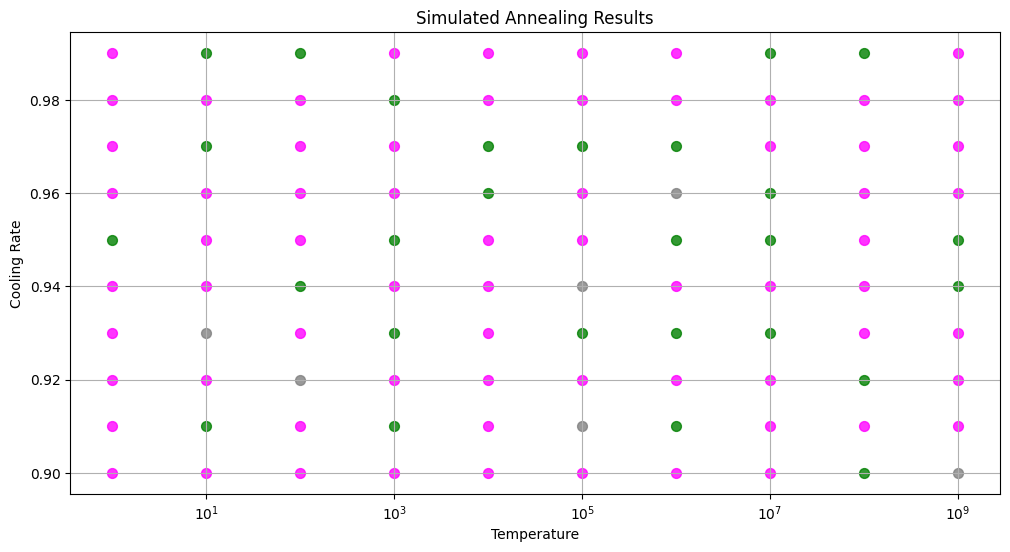

In [82]:
temperatures = [1 * 10 ** i for i in range(0, 10)]
cooling_rates = np.arange(0.9, 1, 0.01, dtype=float)
criteria_boxes = 22
criteria_price = 283.8
best_values = []
result = 0

for temp in temperatures:
    for rate in cooling_rates:
        best_soln,best_boxes,best_price = simulated_annealing(pastry_leftovers, temp, 1, round(rate,2))
        
        if best_boxes <= criteria_boxes and best_price <= criteria_price:
            result = 0
        
        if best_boxes >= criteria_boxes and best_price <= criteria_price:
            result = 1
            
        if best_boxes <= criteria_boxes and best_price >= criteria_price:
            result = 2
            
        if best_boxes >= criteria_boxes and best_price >= criteria_price:
            result = 3

        best_values.append((temp, rate, result))

df = pd.DataFrame(best_values, columns=['temp', 'rate', 'result'])

def assign_color(row):
    if row['result'] == 0:
        return 'gray'
    elif row['result'] == 1:
        return 'cyan'
    elif row['result'] == 2:
        return 'magenta'
    else:
        return 'green'

df['color'] = df.apply(assign_color, axis=1)

# Scatter plot
plt.figure(figsize=(12, 6))
for color in ['gray', 'cyan', 'magenta', 'green']:
    is_color = df['color'] == color
    plt.scatter(df[is_color]['temp'], df[is_color]['rate'], c=color, alpha=0.8, s=50)
plt.xlabel('Temperature')
plt.ylabel('Cooling Rate')
plt.title('Simulated Annealing Results')
plt.xscale('log')
plt.grid(True)
plt.show()

### Interpreting Results

Legend:
- Gray (0): Below criteria for both boxes and price.
- Cyan (1): Meets or exceeds criteria for boxes, below criteria for price.
- Magenta (2): Below criteria for boxes, meets or exceeds criteria for price.
- Green (3): Meets or exceeds criteria for both boxes and price.

Implications:
1. Magenta Points: This result indicates that the solutions found by the simulated annealing algorithm are often financially favorable but are falling short in the number of boxes it can generate.
2. Implication for Remaining Pastries: We have not have enough variants of leftover pastries, which means the remaining boxes might be pastries of the same kind.


## Hill Climbing

**Hill Climbing** is like climbing a hill to find the highest point by repeatedly taking steps in the direction that goes upward, but it may not guarantee finding the highest peak in a complex landscape. Hill climbing requires a starting state, an objective function to evaluate solutions and a method to explore neighboring states. It is suitable for simple optimization problems where local optima are the primary concern and finding a global optimum is not necessary.

### Example: Optimal Roundtrip Route

Suppose you're touring Paris, and you want to visit multiple landmarks in the shortest possible distance, starting and ending from your accomodation. Using the hill climbing algorithm, you start with a random sequence of visiting these landmarks. In each iteration, you swap two landmarks' positions in the sequence and check if this new sequence results in a shorter total distance. If it does, you accept the new sequence; otherwise, you continue testing other swaps. The goal is to minimize the overall travel distance.

$$\text{Objective: } \min_{\text{route}} \sum_{i=1}^{n-1} \text{haversine_distance}(\text{lat}_i, \text{lon}_i, \text{lat}_{i+1}, \text{lon}_{i+1}) + \text{haversine_distance}(\text{lat}_n, \text{lon}_n, \text{lat}_1, \text{lon}_1)$$

The starting state is the initial order of the sequence of landmarks (0 as the start and end) as listed in the raw csv file, which represents how the user uploads a data. The hill climbing algorithm then attempts to refine and optimize this initial order to minimize the total travel distance.

In [86]:
trip = pd.read_csv('data/paris_trip.csv')
print(trip)

                             Address   Latitude  Longitude
0       Saint George Lafayette Hotel  48.876800   2.337900
1                    Arc de Triomphe  48.864828   2.307402
2                    Centre Pompidou  48.860645   2.349670
3                       Eiffel Tower  48.858373   2.289610
4   Domaine National du Palais-Royal  48.867733   2.327385
5                      Musée d'Orsay  48.859965   2.323987
6               Musée de l'Orangerie  48.863792   2.320098
7          Musée des Arts et Métiers  48.866643   2.352863
8                        Musée Rodin  48.855311   2.313261
9                      Louvre Museum  48.860615   2.335069
10              Place de la Concorde  48.866609   2.326023
11                    Palais Garnier  48.859113   2.307562


In [90]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6378 * 1.25 #Earth's mean radius in kilometers + adjusted
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c 
    return round(distance,1)

def calculate_total_distance(data):
    total = 0
    for i in range(len(data)-1):
        distance = haversine_distance(data[i]['Latitude'], data[i]['Longitude'], data[i+1]['Latitude'], data[i+1]['Longitude'])
        total += distance
    total += haversine_distance(data[-1]['Latitude'], data[-1]['Longitude'], data[0]['Latitude'], data[0]['Longitude'])
    return total

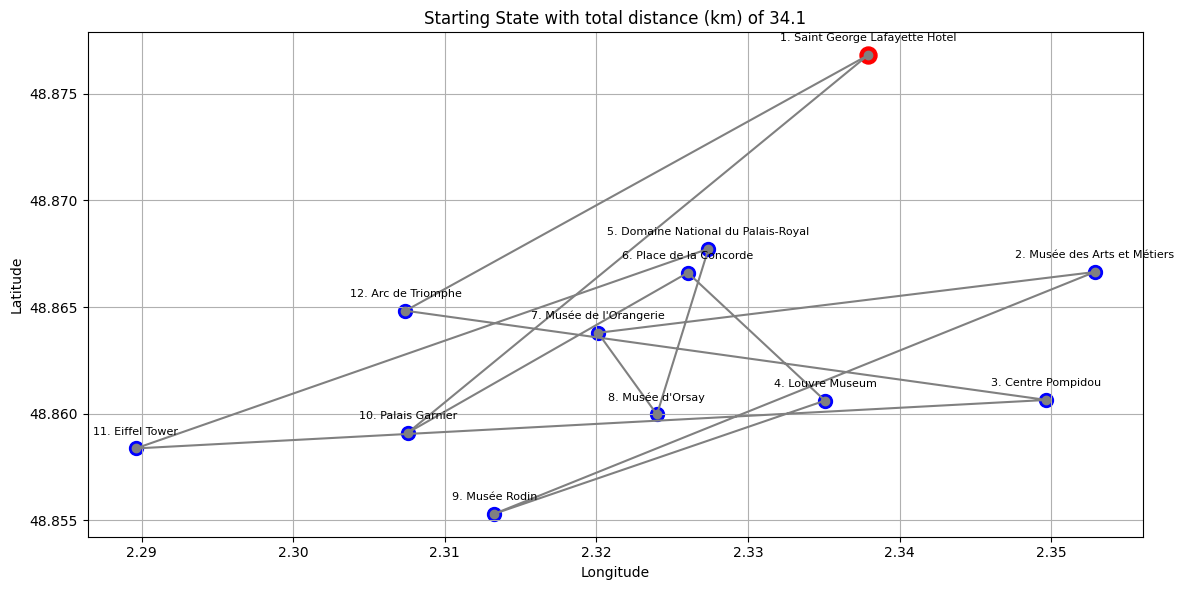

In [91]:
starting_state = trip.to_dict(orient="records")
starting_state_distance = calculate_total_distance(starting_state)
latitudes = [place['Latitude'] for place in starting_state]
longitudes = [place['Longitude'] for place in starting_state]

plt.figure(figsize=(12, 6))
plt.scatter(longitudes, latitudes, c='blue', s=100)
plt.scatter(starting_state[0]['Longitude'], starting_state[0]['Latitude'], c='red', s=150)
plt.plot(longitudes, latitudes, c='grey', linestyle='-', marker='o')
plt.plot([longitudes[-1], longitudes[0]], [latitudes[-1], latitudes[0]], c='grey', linestyle='-')

for i, place in enumerate(optimized_route):
    plt.annotate(f"{i+1}. {place['Address']}", (place['Longitude'], place['Latitude']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Starting State with total distance (km) of " + str(starting_state_distance))
plt.grid(True)
plt.tight_layout()
plt.show()

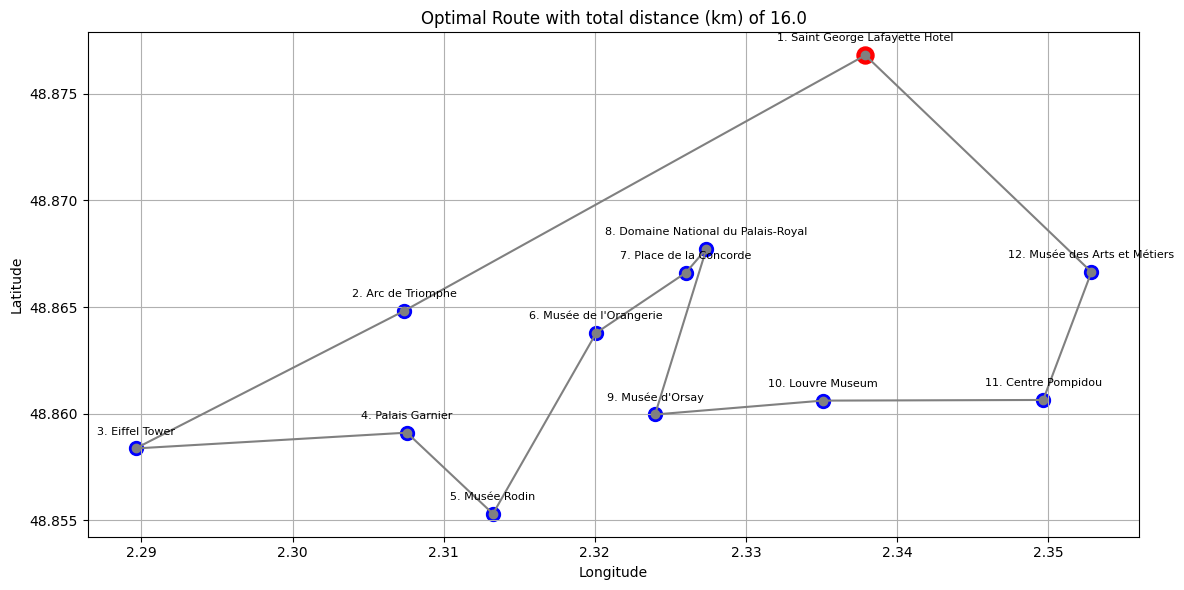

In [93]:
def hill_climbing(data, iterations=1000):
    current_solution = data.to_dict(orient="records")
    current_distance = calculate_total_distance(current_solution)
    
    for _ in range(iterations):
        # Choose two random indices to swap, avoiding the hotel (index 0)
        idx1, idx2 = random.sample(range(1, len(data)), 2)
        
        # Create a new solution by swapping two sights and calculate its distance
        new_solution = current_solution.copy()
        new_solution[idx1], new_solution[idx2] = new_solution[idx2], new_solution[idx1]
        new_distance = calculate_total_distance(new_solution)
        
        # If the new solution is better, update the current solution
        if new_distance < current_distance:
            current_solution = new_solution
            current_distance = new_distance
            
    return current_solution, current_distance

optimized_route, optimized_route_distance = hill_climbing(trip)

latitudes = [place['Latitude'] for place in optimized_route]
longitudes = [place['Longitude'] for place in optimized_route]

plt.figure(figsize=(12, 6))
plt.scatter(longitudes, latitudes, c='blue', s=100)
plt.scatter(optimized_route[0]['Longitude'], optimized_route[0]['Latitude'], c='red', s=150)
plt.plot(longitudes, latitudes, c='grey', linestyle='-', marker='o')
plt.plot([longitudes[-1], longitudes[0]], [latitudes[-1], latitudes[0]], c='grey', linestyle='-')

for i, place in enumerate(optimized_route):
    plt.annotate(f"{i+1}. {place['Address']}", (place['Longitude'], place['Latitude']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimal Route with total distance (km) of " + str(round(optimized_route_distance,1)))
plt.grid(True)
plt.tight_layout()
plt.show()

## Gradient Descent

Gradient descent optimizes functions by repeatedly moving towards the steepest decline. It's effective in complex terrains, especially for adjusting neural network weights. It needs a differentiable function, learning rate, and start point. Success is seen in function convergence, stable loss, and consistency.

### Application: AND Operation

The code trains a single-layer neural network to mimic the behavior of the AND logical operation using the gradient descent optimization technique. By adjusting weights and biases over several iterations, the network learns to produce outputs closely resembling the AND operation results.

Epoch 0, Loss: 0.43615312709159976
Epoch 1000, Loss: 0.03199867395465704
Epoch 2000, Loss: 0.015721969293680898
Epoch 3000, Loss: 0.01007723539601492
Epoch 4000, Loss: 0.007315166336574079
Epoch 5000, Loss: 0.005702291644885482
Epoch 6000, Loss: 0.004653623500969324
Epoch 7000, Loss: 0.003920816177507334
Epoch 8000, Loss: 0.0033815808103234033
Epoch 9000, Loss: 0.0029690875880135767
Epoch 10000, Loss: 0.002643876960515214
Epoch 11000, Loss: 0.0023812150386370665
Epoch 12000, Loss: 0.002164842528686357
Epoch 13000, Loss: 0.0019836481919589598
Epoch 14000, Loss: 0.0018297900135185704
Epoch 15000, Loss: 0.001697580559646121
Epoch 16000, Loss: 0.0015827978070831073
Epoch 17000, Loss: 0.0014822437607687972
Epoch 18000, Loss: 0.0013934530451222994
Epoch 19000, Loss: 0.0013144953441470875


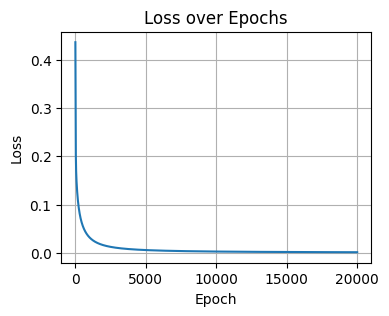

For input [0 0] predicted: 7.492558614324057e-05
For input [0 1] predicted: 0.038191897338788354
For input [1 0] predicted: 0.03819189732621154
For input [1 1] predicted: 0.9546336515606199


In [99]:
# Sigmoid activation and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Mean Squared Error and its derivative
def mse_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return y_pred - y_true

# Gradient Descent for single-layer neural network
def gradient_descent(X, y, epochs, learning_rate):
    np.random.seed(42)
    weights = np.random.rand(X.shape[1], 1)
    biases = np.random.rand(1)
    losses = []

    for epoch in range(epochs):
        z = np.dot(X, weights) + biases
        y_pred = sigmoid(z)

        # Calculate error and gradient
        error = mse_error(y, y_pred)
        losses.append(error)
        
        dZ = mse_derivative(y, y_pred) * sigmoid_derivative(y_pred)
        gradient = np.dot(X.T, dZ)

        # Update weights and biases using Gradient Descent
        weights -= learning_rate * gradient
        biases -= learning_rate * np.sum(dZ)

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {error}')

    return weights, biases, losses

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [0], [0], [1]])

epochs = 20000
learning_rate = 0.1
trained_weights, trained_biases, losses = gradient_descent(X, y, epochs, learning_rate)

plt.figure(figsize=(4, 3))
plt.plot(losses)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

test_input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
for inp in test_input:
    prediction = sigmoid(np.dot(inp, trained_weights) + trained_biases)
    print(f"For input {inp} predicted: {prediction[0]}")

## Genetic Algorithm

Genetic Algorithms are a subset of evolutionary algorithms that use techniques inspired by natural selection, such as inheritance, mutation, selection, and crossover, to generate solutions to optimization and search problems.
* Population: Possible solutions (or chromosomes)
* Mutation: The increment changes to the solution to maintain diversity within the population and avoid premature convergence
* Crossover: Also known as recombination, combines the genetic information of two parent chromosomes to produce new offspring (children)
* child, parent:  a parent is a solution chosen from the current population to participate in crossover, and a child is a new solution created from two parents
* Generation: no. of iterations

|Operator|Pros|Cons|
|:--|:--|:--|
|High Population|Greater Diversity, Improved Robustness|Higher computational Cost,Slower Convergence|
|High Generation|Potential for Better Solutions, More time for evolution|Higher computational Time,Risks of Overfitting|
|High Mutation|Enhanced Exploration,Prevention of Premature Convergence|Loss of Good Solutions by altering too quickly, Reduced Convergence|


### Application: Program Scheduler

You are organizing a 'Dance Intensive Programme' that requires you to create a schedule based on the programme requirements, instructors' expertise and availability, and budget. Assuming that you already have your pool of candidates and program requirements:

In [46]:
from helpers.scheduler import generate_mock_instructors, generate_program_schedule

requirements = {'Ballet':2, 'Contemporary':3, 'Choreography-Improvisation':1, 'Graham-Based Modern': 2, 'Body Conditioning': 1, 'Jazz':1}
instructors = generate_mock_instructors(size=50)

schedule = generate_program_schedule(requirements)

print(schedule)

{1: {'Contemporary', 'Graham-Based Modern'}, 2: {'Ballet', 'Contemporary'}, 3: {'Ballet', 'Jazz'}, 4: {'Body Conditioning', 'Graham-Based Modern'}, 5: {'Contemporary', 'Choreography-Improvisation'}}


### Implementation

1. Initialization: initialize_schedule function creates an initial population of schedules, randomly assigning instructors to different styles and days.
2. Fitness Function: The fitness function calculates a score for each schedule based on the trust score, the remaining budget, and the total cost. If the total cost is over the budget, the function returns -1.
3. Parent Selection: select_parent_based_on_fitness function picks parents for crossover based on fitness scores, choosing the schedule with the highest fitness.
4. Crossover and Mutation: Inside the loop through generations, parents are chosen, and crossover and mutation functions are applied to create a new population.
5. Best Schedule Selection: After the iterations are completed, the code finds the schedule with the highest fitness score, which represents the best solution.

In [97]:
def initialize_schedule(population_size, schedule, instructors):
    population = []
    for _ in range(population_size):
        new_schedule = {}
        for day, styles in schedule.items():
            new_schedule[day] = {}
            for style in styles:
                instructors_for_style = [instructor for instructor, details in instructors.items() if style in details['expertise']]
                selected_instructor = random.choice(instructors_for_style) if instructors_for_style else None
                new_schedule[day][style] = selected_instructor
        population.append(new_schedule)
    return population

def fitness(schedule, instructors, budget):
    total_cost = 0
    total_trust_score = 0
    num_classes = 0
    for day, styles in schedule.items():
        for style, instructor in styles.items():
            if instructor is not None:
                total_cost += instructors[instructor]['rate_per_hour']
                total_trust_score += instructors[instructor]['trust_score']
                num_classes += 1
    if total_cost > budget:
        return -1
    trust_score_factor = total_trust_score / (num_classes * 5) if num_classes > 0 else 0
    remaining_budget_factor = (budget - total_cost) / budget
    fitness_score = (trust_score_factor * 5) + (5 - remaining_budget_factor)
    return fitness_score

def select_parent_based_on_fitness(population, fitness_scores):
    return max(zip(population, fitness_scores), key=lambda x: x[1])[0]

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(schedule))
    child = {day: (parent1[day] if day < crossover_point else parent2[day]) for day in schedule}
    return child

def mutate(child):
    day_to_mutate = random.choice(list(schedule.keys()))
    styles = schedule[day_to_mutate]
    for style in styles:
        instructors_for_style = [instructor for instructor, details in instructors.items() if style in details['expertise']]
        selected_instructor = random.choice(instructors_for_style) if instructors_for_style else None
        child[day_to_mutate][style] = selected_instructor
    return child

population_size = 150
generations = 1000
mutation_rate = 0.01
budget = 900

population = initialize_schedule(population_size, schedule, instructors)

for generation in range(generations):
    fitness_scores = [fitness(sch, instructors, budget) for sch in population]
    parents = [select_parent_based_on_fitness(population, fitness_scores) for _ in range(population_size)]
    new_population = []
    for i in range(0, population_size, 2):
        child1 = crossover(parents[i], parents[i + 1])
        child2 = crossover(parents[i + 1], parents[i])
        if random.random() < mutation_rate:
            child1 = mutate(child1)
        if random.random() < mutation_rate:
            child2 = mutate(child2)
        new_population.extend([child1, child2])
    population = new_population

best_schedule = max(population, key=lambda x: fitness(x, instructors, budget))
best_schedule_fitness_score = -float('inf')
best_schedule = None

for candidate_schedule in population:
    candidate_fitness_score = fitness(candidate_schedule, instructors, budget)
    if candidate_fitness_score > best_schedule_fitness_score:
        best_schedule_fitness_score = candidate_fitness_score
        best_schedule = candidate_schedule

print("Best schedule:", best_schedule)
print("Fitness score of the best schedule:", best_schedule_fitness_score)

Best schedule: {1: {'Contemporary': 'instructor_43', 'Graham-Based Modern': 'instructor_27'}, 2: {'Ballet': 'instructor_13', 'Contemporary': 'instructor_32'}, 3: {'Ballet': 'instructor_1', 'Jazz': 'instructor_18'}, 4: {'Body Conditioning': 'instructor_41', 'Graham-Based Modern': 'instructor_22'}, 5: {'Contemporary': 'instructor_11', 'Choreography-Improvisation': 'instructor_47'}}
Fitness score of the best schedule: 8.911111111111111


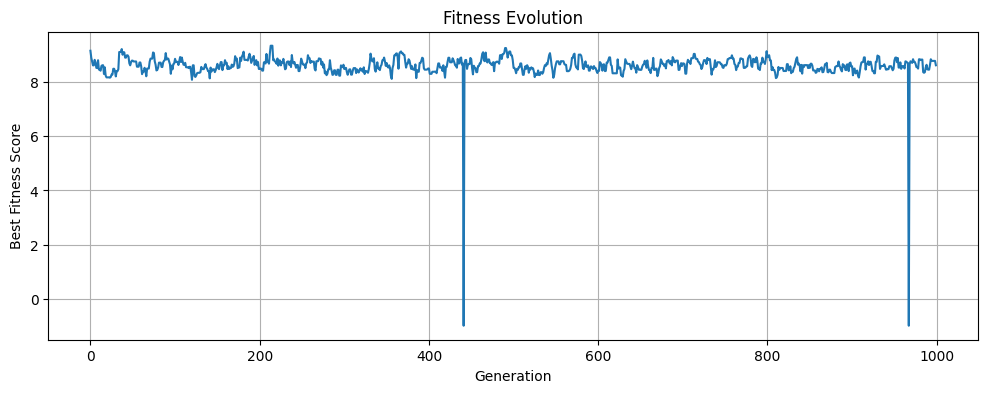

In [98]:
import matplotlib.pyplot as plt

best_fitness_scores = []

population = initialize_schedule(population_size, schedule, instructors)

for generation in range(generations):
    fitness_scores = [fitness(sch, instructors, budget) for sch in population]
    # Append the maximum fitness score of this generation to the list
    best_fitness_scores.append(max(fitness_scores))
    
    parents = [select_parent_based_on_fitness(population, fitness_scores) for _ in range(population_size)]
    new_population = []
    for i in range(0, population_size, 2):
        child1 = crossover(parents[i], parents[i + 1])
        child2 = crossover(parents[i + 1], parents[i])
        if random.random() < mutation_rate:
            child1 = mutate(child1)
        if random.random() < mutation_rate:
            child2 = mutate(child2)
        new_population.extend([child1, child2])
    population = new_population

plt.figure(figsize=(12, 4))
plt.plot(best_fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Fitness Evolution')
plt.grid(True)
plt.show()

### Interpreting Fitness Score Results
* If the score is -1, it always mean that the budget constraint is not satisfied,
* The maximum score is 10, a higher score means a better fitness score.
* The up-downward trends tells us the algorithm is exploring the local optima
* These parameters also show us effective constraint handling (there were only 2 deep valleys out of 1000 generations). It suggests that the algorithm is able to effectively navigate the search space without often straying into infeasible regions.  

## Particle Swarm Optimization

Particle Swarm Optimization is an optimization technique inspired by the social behavior of birds and fish. Similar to GA, it is population-based optimization technique but does not have genetic operators like crossover and mutation. PSO are more suitable for continuous optimization problems.

* Particles:  Each particle represents a point in the search space, corresponding to a particular solution to the problem.
* Swarm Size: Number of particles in the swarm. A larger swarm size may offer better exploration but can be more computationally expensive.
* Velocity: Each particle has a velocity that determines how it will move in the search space. The velocity is updated based on personal and global best positions, allowing particles to explore the space and converge to the optimal solution.
* Memory: Particles remember their best personal position encountered so far, which contributes to the velocity update.

In the code snippet below, PSO is implemented to find the global minimum of the sinusoidal quadratic landscape. This complex function, with a sinusoidal wave pattern and a quadratic bowl centered at (2.5, 2.5), models a challenging terrain filled with local extremes. The landscape is an apt representation of real-world issues like wireless signal optimization. Its sinusoidal component reflects fluctuating signal strengths, and the quadratic bowl symbolizes network stability. The example below is inspired from Brownlee's [A Gentle Introduction to PSO](https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/)

MovieWriter imagemagick unavailable; using Pillow instead.


PSO found best solution at f([2.59494384 3.02238392])=-0.6525924141670724
Global optimal at f([2.5757575757575757, 3.0303030303030303])=-0.12464647895832004


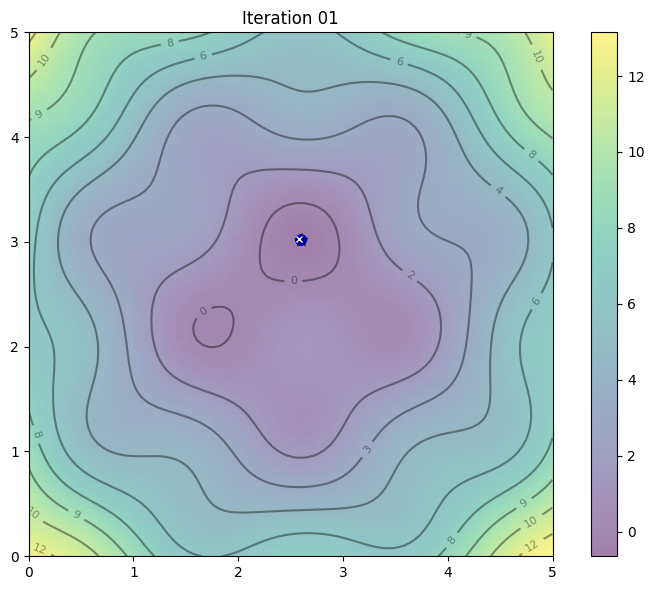

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def sinusoidal_quadratic_landscape(x,y):
    return np.sin(3 * x) * np.cos(3 * y) + (x - 2.5)**2 + (y - 2.5)**2
    
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = sinusoidal_quadratic_landscape(x, y)

# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

# Hyper-parameter of the algorithm
c1 = c2 = 0.2
w = 0.8

# Create particles
n_particles = 30
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

# Initialize data
pbest = X
pbest_obj = sinusoidal_quadratic_landscape(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = sinusoidal_quadratic_landscape(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()

fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])

def animate(i):
    title = 'Iteration {:02d}'.format(i)
    update()
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot

anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
anim.save("pso_example.gif", dpi=120, writer="imagemagick")

print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))

## Learning Resources

- Trollman, Frank. Artificial Intelligence Basics. CODE University of Applied Sciences. [code.berlin](https://code.berlin/en/about/team/)
- CS50 at Harvard University. Week 3: Optimisation. [cs50.harvard.edu](https://cs50.harvard.edu/ai/2020/weeks/3/)
- Brownlee, Jason. Simulated Annealing from Scratch in Python. [machinelearningmastery.com](https://machinelearningmastery.com/simulated-annealing-from-scratch-in-python/)
- Brownlee, Jason. Simple Genetic Algorithm From Scratch in Python.[machinelearningmastery.com](https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/)
- Brownlee, Jason. A Gentle Introduction to Particle Swarm Optimization.[machinelearningmastery.com](https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/)
- Dhondge, Tanishka.  Hill Climbing Algorithm in Python. [askpython.com](https://www.askpython.com/python/examples/hill-climbing-algorithm-in-python)
- Wikipedia. Harvesine Formula. [en.wikipedia.org](https://en.wikipedia.org/wiki/Haversine_formula)
- Wikipedia. Particle Swarm Optimization. [en.wikipedia.org](https://en.wikipedia.org/wiki/Particle_swarm_optimization)
- GeekForGeeks. Introduction Hill Climbing AI. [geeksforgeeks.org](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)
- GeekForGeeks. Genetic Algorithms. [geeksforgeeks.org](https://www.geeksforgeeks.org/genetic-algorithms/)
- DelSole, Michael. A Single-Layer Artificial Neural Network in 20 Lines of Python. [medium.com](https://medium.com/@michaeldelsole/a-single-layer-artificial-neural-network-in-20-lines-of-python-ae34b47e5fef)
- Dabbura, Imad. Gradient Descent Algorithm and Its Variants. Towards Data Science Inc. [towardsdatascience.com](https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3)
- http://www.swarmintelligence.org/tutorials.php
- Gad, A.G. Particle Swarm Optimization Algorithm and Its Applications: A Systematic Review. Chapter 6: Applications.[link.springer.com](https://link.springer.com/article/10.1007/s11831-021-09694-4)
- PySwarm. Particle swarm optimization (PSO) with constraint support. [pythonhosted.org](https://pythonhosted.org/pyswarm/)

